In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format='svg'

import numpy as np
np.set_printoptions(precision=6, suppress=True)
np.set_printoptions(threshold=np.inf)

from shl_scripts.shl_experiments import SHL
from classification import SparseClassif


In [2]:
tag ='2017-06-01_MNIST_MEUL_DEBUG_'
DEBUG_DOWNSCALE, verbose = 10, 10
tag ='2017-06-01_MNIST_MEUL_'

DEBUG_DOWNSCALE, verbose = 1, 10
patch_size = (28,28)
n_dictionary = 15**2
l0_sparseness = 7
n_iter = 2**14
eta = 0.01
eta_homeo = 0.01
verbose = 0
list_figures=[]#['show_dico']
n_hidden = 100

In [3]:
shl = SHL(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, 
            eta=eta, eta_homeo=eta_homeo, verbose=verbose,
            n_iter=n_iter, patch_size=patch_size, l0_sparseness=l0_sparseness,
            n_dictionary=n_dictionary)
matname = tag

sc = SparseClassif(shl, matname)
sc.dico = shl.learn_dico(data=sc.training_image, matname=matname, list_figures=list_figures)    

In [4]:
wrapped_training_data, wrapped_test_data_final, n_test = sc.format_data()
(wrapped_test_data_final)

In [5]:
2**np.arange(4, 8)

array([ 16,  32,  64, 128])

In [6]:
sc.learn()

In [7]:
print( 'Result = ', sc.result() )

Result =  0.01988


 ----- learning with eta_ : 0.1 -----
 ----- learning with eta_ : 0.1778279410038923 -----
 ----- learning with eta_ : 0.31622776601683794 -----
 ----- learning with eta_ : 0.5623413251903491 -----
 ----- learning with eta_ : 1.0 -----
 ----- learning with eta_ : 1.7782794100389228 -----
 ----- learning with eta_ : 3.1622776601683795 -----
 ----- learning with eta_ : 5.623413251903491 -----
 ----- learning with eta_ : 10.0 -----


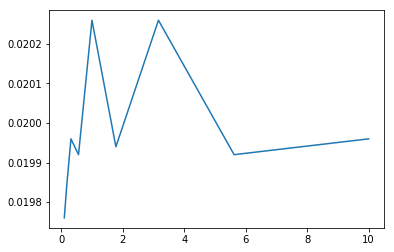

In [8]:
etas = np.logspace(-1, 1, 9, base=10)

results = []
for eta_ in etas:
    print(" ----- learning with eta_ : {} -----".format(eta_))
    sc = SparseClassif(shl, matname, eta=eta_)
    sc.dico = shl.learn_dico(data=sc.training_image, matname=matname, list_figures=list_figures)    
    sc.learn()
    results.append(sc.result())

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(etas, results)

 ----- learning with n_hidden : 16 -----
 ----- learning with n_hidden : 32 -----
 ----- learning with n_hidden : 64 -----
 ----- learning with n_hidden : 128 -----


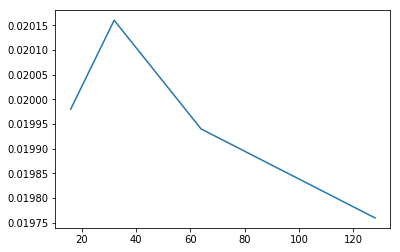

In [9]:
n_hiddens = 2**np.arange(4, 8)
results = []
for n_hidden_ in n_hiddens:
    print(" ----- learning with n_hidden : {} -----".format(n_hidden_))
    sc = SparseClassif(shl, matname, n_hidden=n_hidden_)
    sc.dico = shl.learn_dico(data=sc.training_image, matname=matname, list_figures=list_figures)    
    sc.learn()
    results.append(sc.result())

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(n_hiddens, results)

 ----- learning with mini_batch_size : 16 -----
 ----- learning with mini_batch_size : 32 -----
 ----- learning with mini_batch_size : 64 -----
 ----- learning with mini_batch_size : 128 -----


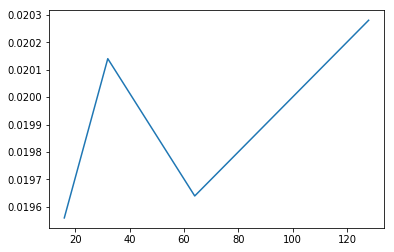

In [10]:
mini_batch_sizes = 2**np.arange(4, 8)
results = []
for mini_batch_size_ in mini_batch_sizes:
    print(" ----- learning with mini_batch_size : {} -----".format(mini_batch_size_))
    sc = SparseClassif(shl, matname, mini_batch_size=mini_batch_size_)
    sc.dico = shl.learn_dico(data=sc.training_image, matname=matname, list_figures=list_figures)    
    sc.learn()
    results.append(sc.result())

plt.plot(mini_batch_sizes, results)

 ----- learning with epochs : 16 -----
 ----- learning with epochs : 32 -----
 ----- learning with epochs : 64 -----
 ----- learning with epochs : 128 -----


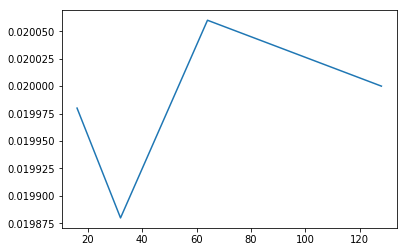

In [11]:
epochss = 2**np.arange(4, 8)
results = []
for epochs_ in epochss:
    print(" ----- learning with epochs : {} -----".format(epochs_))
    sc = SparseClassif(shl, matname, epochs=epochs_)
    sc.dico = shl.learn_dico(data=sc.training_image, matname=matname, list_figures=list_figures)    
    sc.learn()
    results.append(sc.result())

plt.plot(epochss, results)

In [12]:
results


[0.01998, 0.01988, 0.02006, 0.02]